<a href="https://colab.research.google.com/github/Alfaalputra/Alfaalputra/blob/main/Natural_Language_Processing_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!wget --no-check-certificate \
    https://data.mendeley.com/datasets/k42j7x2kpn/1/files/5df17537-cd9a-4df8-9e26-89931aef005b/all_agree.csv?dl=1 \
    -O /tmp/clickbait.csv

--2020-08-22 12:36:01--  https://data.mendeley.com/datasets/k42j7x2kpn/1/files/5df17537-cd9a-4df8-9e26-89931aef005b/all_agree.csv?dl=1
Resolving data.mendeley.com (data.mendeley.com)... 162.159.133.86, 162.159.130.86
Connecting to data.mendeley.com (data.mendeley.com)|162.159.133.86|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/aca40896-c1dc-45f9-b649-e3d006b630e4 [following]
--2020-08-22 12:36:01--  https://md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com/aca40896-c1dc-45f9-b649-e3d006b630e4
Resolving md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)... 52.218.102.48
Connecting to md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com (md-datasets-public-files-prod.s3.eu-west-1.amazonaws.com)|52.218.102.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 691752 (676K) [text/csv]
Saving to:

In [ ]:
import pandas as pd

df = pd.read_csv('/tmp/clickbait.csv',delimiter=',',encoding='latin-1')
df.head()


,title,label,label_score
0,"Masuk Radar Pilwalkot Medan, Menantu Jokowi Be...",non-clickbait,0
1,Malaysia Sudutkan RI: Isu Kabut Asap hingga In...,non-clickbait,0
2,Viral! Driver Ojol di Bekasi Antar Pesanan Mak...,clickbait,1
3,"Kemensos Salurkan Rp 7,3 M bagi Korban Kerusuh...",non-clickbait,0
4,MPR: Amandemen UUD 1945 Tak Akan Melebar ke Ma...,non-clickbait,0


In [ ]:
import tensorflow as tf
import numpy as np
import csv
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

corpus = []
num_sentences = 0
with open("/tmp/clickbait.csv") as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    next(reader)
    for row in reader:
        list_item = []
        if (row[2] == '0'):
          label = 0
        else:
          label = 1
        list_item.append(label)
        list_item.append(row[0])
        num_sentences = num_sentences + 1
        corpus.append(list_item)

print(len(corpus))

8613


In [ ]:
print(corpus[1])

[0, 'Malaysia Sudutkan RI: Isu Kabut Asap hingga Invasi Babi']


In [ ]:
#define the hyperparameters

embedding_dim = 100
max_length = 16
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size=len(corpus)
test_portion=.2

In [ ]:
import random
sentences = []
labels = []
random.shuffle(corpus)
for x in range(training_size):
  sentences.append(corpus[x][1])
  labels.append(corpus[x][0])
print(len(sentences))
print(len(labels))

NameError: ignored

In [ ]:
#Tokenize the sentence and padding them

tokenizer = Tokenizer(oov_token=oov_tok)
tokenizer.fit_on_texts(sentences)
word_index = tokenizer.word_index

vocab_size = len(word_index)

sequences = tokenizer.texts_to_sequences(sentences)
padded = pad_sequences(sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

split = int(test_portion * training_size)

test_sequences = padded[0:split]
test_labels = np.array(labels[0:split])

train_sequences = padded[split:]
train_labels = np.array(labels[split:])


print(len(train_sequences))
print(len(train_labels))
print(len(test_sequences))
print(len(test_labels))


6891
6891
1722
1722


In [ ]:
# Note this is the 100 dimension version of GloVe from Stanford
# I unzipped and hosted it on my site to make this notebook easier
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt \
    -O /tmp/glove.6B.100d.txt
embeddings_index = {};
with open('/tmp/glove.6B.100d.txt') as f:
    for line in f:
        values = line.split();
        word = values[0];
        coefs = np.asarray(values[1:], dtype='float32');
        embeddings_index[word] = coefs;

embeddings_matrix = np.zeros((vocab_size+1, embedding_dim));
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word);
    if embedding_vector is not None:
        embeddings_matrix[i] = embedding_vector;

--2020-08-22 12:36:06--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/glove.6B.100d.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 172.217.204.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 347116733 (331M) [text/plain]
Saving to: ‘/tmp/glove.6B.100d.txt’

/tmp/glove.6B.100d. 100%[===================>] 331.04M  86.8MB/s    in 3.8s    

2020-08-22 12:36:10 (86.8 MB/s) - ‘/tmp/glove.6B.100d.txt’ saved [347116733/347116733]



In [ ]:
#build and train the model

model = tf.keras.Sequential([
    tf.keras.layers.Embedding(vocab_size+1, embedding_dim, input_length=max_length, weights=[embeddings_matrix], trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

num_epochs = 100
history = model.fit(train_sequences, train_labels, epochs=num_epochs, validation_data=(test_sequences, test_labels), verbose=1)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 16, 100)           1393600   
_________________________________________________________________
dropout (Dropout)            (None, 16, 100)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, 64)                34048     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 1,427,713
Trainable params: 34,113
Non-trainable params: 1,393,600
_________________________________________________________________
Epoch 1/100
216/216 [==============================] - 3s 15ms/step - loss: 0.5474 - accuracy: 0.7220 - val_loss: 0.4672 - val_accuracy: 0.7782
Epoch 2/100
216/216 [==============================] - 2s 11ms/step - loss: 0.4568 - accuracy: 

<Figure size 432x288 with 0 Axes>

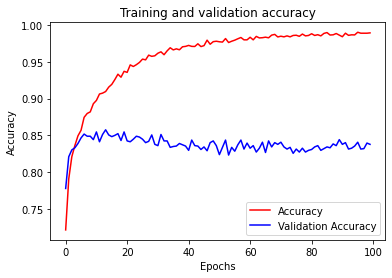

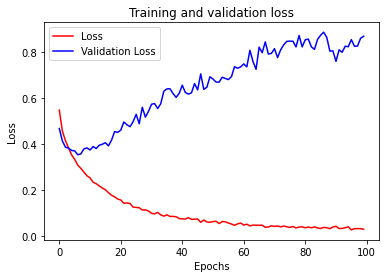

<Figure size 432x288 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc=history.history['accuracy']
val_acc=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']

epochs=range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and validation accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["Accuracy", "Validation Accuracy"])

plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Training and validation loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()


# Expected Output
# A chart where the validation loss does not increase sharply!